In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt

In [3]:
print(tf.version.VERSION)

2.15.0


## **Prepare Fashion-MNIST data**

The first step is to get data ready for training.



### **Loading**

In [4]:
# load the Fashion MNIST dataset and it's OK to use just the training data
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [5]:
train_images.shape

(60000, 28, 28)

There are 60,000 training gray scale images in Fashion-MNIST.

In [6]:
type(train_images)

numpy.ndarray

## **Visualization**

I always like to visualize the training data to get an idea of what the images look like.



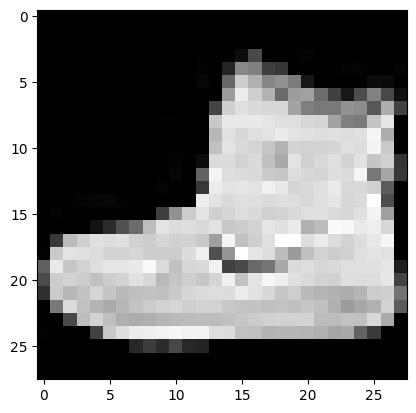

In [7]:
plt.figure()
plt.imshow(train_images[0], cmap='gray')
plt.show()

## **Preprocessing**

In [8]:
# Reshape data and also convert the data type to 'float32'
print(train_images.shape)
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
print(train_images.shape)

# Normalize the images to [-1, 1] which is the range of the tanh activation
train_images = (train_images - 127.5) / 127.5

(60000, 28, 28)
(60000, 28, 28, 1)


## **The generator model**

Define the generator model architecture with the Keras Sequential API.

Use ReLU except for the last layer which has tanh as the activation.

The job of the generator is to make images, to do so in DCGAN, we feed random noise as input to the generator and upsample till the desired image size becomes 28x28x1.

In [9]:
# latent dimension of the random noise
LATENT_DIM = 100
# weight initializer for G per DCGAN paper
WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# number of channels, 1 for gray scale and 3 for color images
CHANNELS = 1

In [10]:
def build_generator():
    # create a Keras Sequential model
    model = Sequential(name="generator")

    # prepare for reshape: FC => BN => RN layers, note: input shape defined in the 1st Dense layer
    model.add(layers.Dense(7 * 7 * 256, input_dim=LATENT_DIM))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # 1D => 3D: reshape the output of the previous layer
    model.add(layers.Reshape((7, 7, 256)))

    # upsample to 14x14: apply a transposed CONV => BN => RELU
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())
    model.add((layers.ReLU()))

    # upsample to 28x28: apply a transposed CONV => BN => RELU
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())
    model.add((layers.ReLU()))

    # final layer: Conv2D with tanh activation
    model.add(layers.Conv2D(CHANNELS, (5, 5), padding="same", activation="tanh"))

    # return the generator model
    return model

In [11]:
# build the generator model
generator = build_generator()
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1266944   
                                                                 
 batch_normalization (Batch  (None, 12544)             50176     
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 128)       819328    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 128)       51

## **The discriminator model**
Define the discriminator model architecture with the Keras Sequential API

In [12]:
def build_discriminator(width, height, depth, alpha=0.2):
    # create a Keras Sequential model
    model = Sequential(name="discriminator")
    input_shape = (height, width, depth)

    # first set of CONV => BN => leaky ReLU layers
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same",
        input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # second set of CONV => BN => leacy ReLU layers
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # flatten and apply dropout
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3))

    # sigmoid in the last layer outputs a single value for binary classification
    model.add(layers.Dense(1, activation="sigmoid"))

    # return the discriminator model
    return model

In [13]:
# build the discriminator model
discriminator = build_discriminator(28, 28, 1)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 batch_normalization_3 (Bat  (None, 14, 14, 64)        256       
 chNormalization)                                                
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 batch_normalization_4 (Bat  (None, 7, 7, 128)         512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)       

## **Define DCGAN class: override train_step**

Subclass keras.Model and override train_step to implement the DCGAN architecture. This is where the magic happens and the heart of the DCGAN implementation.

**The discriminator loss** includes both the loss from the real images and the loss from the fake images.

**The generator loss** is calculated with thefake images.

In [14]:
class DCGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):

        batch_size = tf.shape(real_images)[0]
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Step 1. Train the discriminator with both real images (label as 1) and fake images (classified as label as 0)
        with tf.GradientTape() as tape:
            # Compute discriminator loss on real images
            pred_real = self.discriminator(real_images, training=True)
            d_loss_real = self.loss_fn(tf.ones((batch_size, 1)), pred_real)

            # Compute discriminator loss on fake images
            fake_images = self.generator(noise)
            pred_fake = self.discriminator(fake_images, training=True)
            d_loss_fake = self.loss_fn(tf.zeros((batch_size, 1)), pred_fake)

            # total discriminator loss
            d_loss = (d_loss_real + d_loss_fake)/2
        # Compute discriminator gradients
        grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        # Update discriminator weights
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_variables))

        # Step 2. Train the generator (do not update weights of the discriminator)
        # G wants D to think the fake images are real (label as 1)
        misleading_labels = tf.ones((batch_size, 1))

        with tf.GradientTape() as tape:
            fake_images = self.generator(noise, training=True)
            pred_fake = self.discriminator(fake_images, training=True)
            g_loss = self.loss_fn(misleading_labels, pred_fake)
        # Compute generator gradients
        grads = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update generator weights
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

## **Use Keras Callback to monitor training**

The nice thing about overriding train_step of keras.Model is that we can subclass Callback to monitor our DCGAN training.

I use the seed noise to create images (with the generator model) throughout the training to visually inspect the progress of the generator. You can also save the generator model at the end of the training which could potentially be used for inference later.

In [15]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim

        # Create random noise seed for visualization during training
        self.seed = tf.random.normal([16, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        # random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        # generated_images = self.model.generator(random_latent_vectors)
        generated_images = self.model.generator(self.seed)
        generated_images = (generated_images * 127.5) + 127.5
        generated_images.numpy()

        fig = plt.figure(figsize=(4, 4))
        for i in range(self.num_img):
            plt.subplot(4, 4, i+1)
            img = keras.utils.array_to_img(generated_images[i])
            plt.imshow(img, cmap='gray')
            plt.axis('off')
        plt.savefig('epoch_{:03d}.png'.format(epoch))
        plt.show()

    def on_train_end(self, logs=None):
        self.model.generator.save('/content/drive/MyDrive/Colab Notebooks/Generative Adversarial Neural Network/models/generator.h5')

## **Train the DCGAN model**

Compile the dcgan model, with the Adam optimizer, learning rate of 0.0002, and the Binary Cross Entropy loss functionas recommended by the paper. In future GAN tutorials, you will learn other loss functions for other GAN variants.

Putting together the dcgan model.

In [16]:
dcgan = DCGAN(discriminator=discriminator, generator=generator, latent_dim=LATENT_DIM)

Compile the dcgan model.

In [17]:
LR = 0.0002 # learning rate

dcgan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=LR, beta_1 = 0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=LR, beta_1 = 0.5),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

Now we simply call model.fit() to traing the dcgan model!

Epoch 1/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.1614 - g_loss: 0.8585

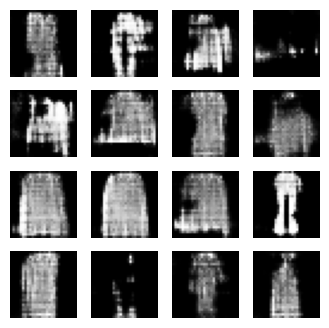

1875/1875 [==============================] - 1796s 955ms/step - d_loss: 0.1614 - g_loss: 0.8585
Epoch 2/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.5962 - g_loss: 0.9958

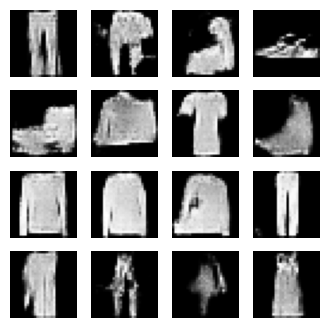

1875/1875 [==============================] - 1699s 906ms/step - d_loss: 0.5962 - g_loss: 0.9958
Epoch 3/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6532 - g_loss: 0.9340

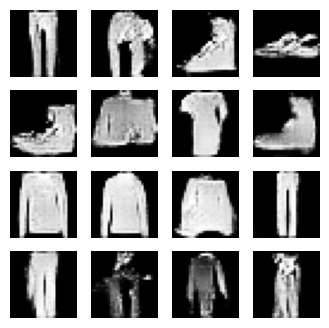

1875/1875 [==============================] - 1682s 897ms/step - d_loss: 0.6532 - g_loss: 0.9340
Epoch 4/50
 249/1875 [==>...........................] - ETA: 24:12 - d_loss: 0.6570 - g_loss: 0.8845

In [ ]:
NUM_EPOCHS = 50 # number of epochs
dcgan.fit(train_images, epochs=NUM_EPOCHS, callbacks=[GANMonitor(num_img=16, latent_dim=LATENT_DIM)])